<a href="https://colab.research.google.com/github/Nallasailaja/spam_email_detection/blob/main/spam_email_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Download stopwords (only needed once)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset (Make sure to upload the file in Colab)
df = pd.read_csv("/content/spam.csv", encoding="ISO-8859-1")

# Keep only necessary columns
df = df[['Category', 'Message']]

# Rename columns
df.columns = ['label', 'text']

# Convert labels: 'spam' → 1, 'ham' → 0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply text preprocessing
df['processed_text'] = df['text'].apply(preprocess_text)

# Display dataset preview
df.head()

,label,text,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Apply TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to avoid overfitting
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Train a Logistic Regression model with optimized parameters
model = LogisticRegression(solver='liblinear', C=10)  # Tuned for better accuracy
model.fit(X_train_tfidf, y_train)

LogisticRegression(C=10, solver='liblinear')

In [ ]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Model Accuracy: {accuracy:.2f}%")  # Display accuracy

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model Accuracy: 97.94%
Confusion Matrix:
[[965   1]
 [ 22 127]]


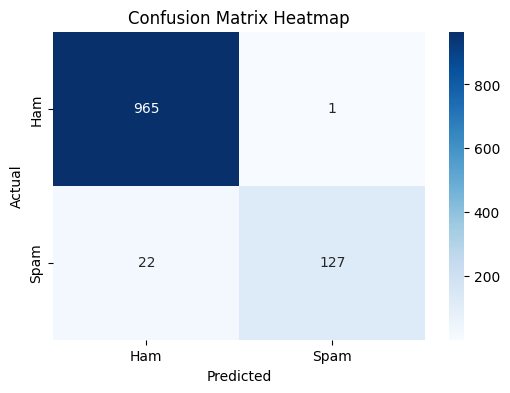

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Check model performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Function to predict if a message is spam or ham
def predict_spam(message):
    processed_message = preprocess_text(message)  # Preprocess input text
    message_tfidf = tfidf_vectorizer.transform([processed_message])  # Convert to TF-IDF

    # Ensure proper feature handling
    if message_tfidf.shape[1] != X_train_tfidf.shape[1]:
        print("Error: Mismatch in feature dimensions. Retrain TF-IDF with consistent features.")
        return None

    prediction = model.predict(message_tfidf)[0]  # Predict class
    probability = model.predict_proba(message_tfidf)[0][1]  # Probability of spam

    return f"Prediction: {'Spam' if prediction == 1 else 'Ham'} (Confidence: {probability:.2f})"

# Example usage with real-time input
while True:
    user_message = input("\nEnter an email message (or type 'exit' to stop): ")
    if user_message.lower() == "exit":
        break
    print(predict_spam(user_message))


Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Enter an email message (or type 'exit' to stop): Your Bank Account Has Been Suspended!
Prediction: Ham (Confidence: 0.11)

Enter an email message (or type 'exit' to stop): exit
